This code is for the arrhythmia experiment conducted in January 2024. The aim was to identify compounds useful for increase HRV in the embryonic zebrafish heart.

In [1]:
import optical_gating_analysis as OG
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import helper_functions

In [3]:
# Dataset settings
# Fish 1, pre and post
data_src = r"E:\data\my data\January 2024 Arrhythmic\Dosage tests\Carbononxolone\Fish 1\Pre\2024-01-18 15.31.27 vid\Allied Vision Technologies GS650 0001f61c\*tif"
data_src = r"E:\data\my data\January 2024 Arrhythmic\Dosage tests\Carbononxolone\Fish 1\Post\2024-01-18 15.47.08 vid\Allied Vision Technologies GS650 0001f61c\*tif"
# Fish 2, pre and post
data_src = r"E:\data\my data\January 2024 Arrhythmic\Dosage tests\Carbononxolone\Fish 2\pre\2024-01-18 16.07.30 vid\Allied Vision Technologies GS650 0001f61c\*tif"
#data_src = r"E:\data\my data\January 2024 Arrhythmic\Dosage tests\Carbononxolone\Fish 2\post\2024-01-18 16.21.09 vid\Allied Vision Technologies GS650 0001f61c\*tif"
frame_rate = 120
frame_limit = 4000

# Run OOG

In [4]:
oog = OG.BasicOpticalGating()
oog.sequence_manager.set_source(data_src)
oog.sequence_manager.max_frames = frame_limit
oog.run()

Setting source to E:\data\my data\January 2024 Arrhythmic\Dosage tests\Carbononxolone\Fish 2\pre\2024-01-18 16.07.30 vid\Allied Vision Technologies GS650 0001f61c\*tif
Getting reference sequence
Getting SADs
Getting phases


# OOG outputs

In [5]:
print(f"Reference period: ~{oog.sequence_manager.reference_period:.2f} frames")
print(f"Reference period: ~{oog.sequence_manager.reference_period / frame_rate:.2f} seconds")
print(f"Reference heartrate: ~{frame_rate / oog.sequence_manager.reference_period:.2f} beats per second")

Reference period: ~62.54 frames
Reference period: ~0.52 seconds
Reference heartrate: ~1.92 beats per second


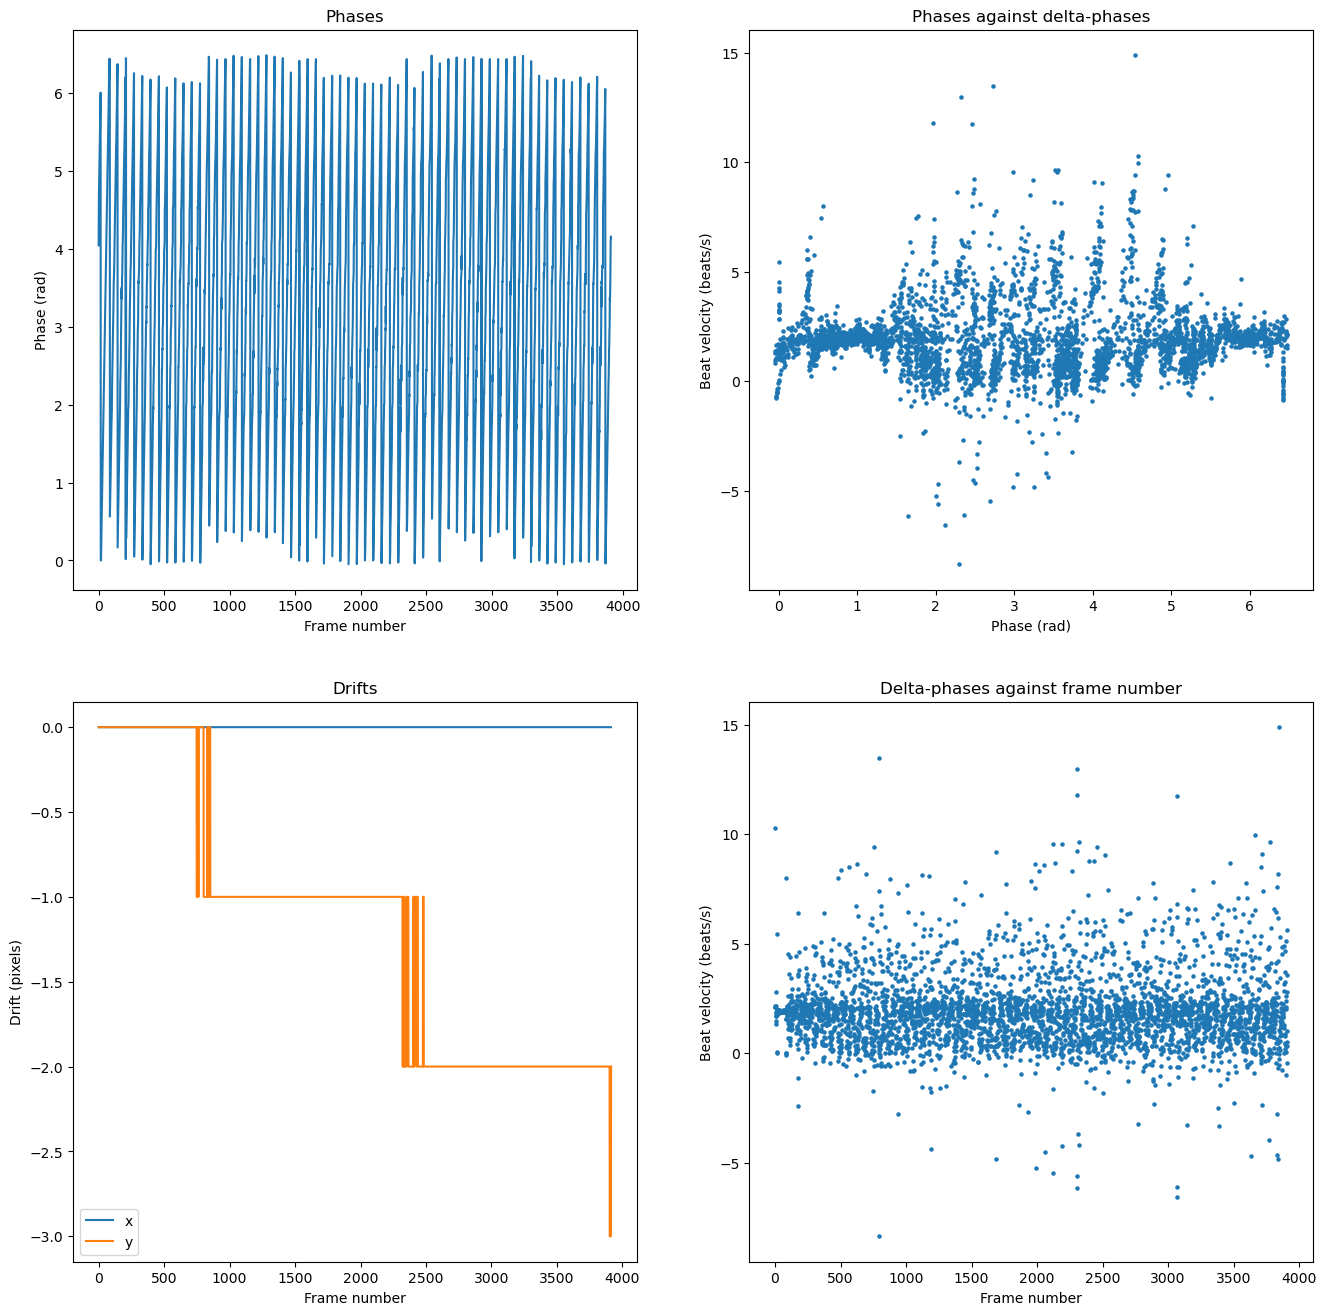

In [6]:
helper_functions.plot_oog_general(oog.phases, oog.delta_phases, oog.drifts, frame_rate)

# Average HR

In [7]:
sadsmin = []
for i in range(len(oog.sads)):
    sadsmin.append(np.min(oog.sads[i]))

In [8]:
phases = oog.phases
unwrapped_phases = oog.unwrapped_phases

i_prev = 0
beat_indices = []
for i in range(1, phases.shape[0]):
    if (phases[i] - phases[i - 1]) < -np.pi:
        if abs(i_prev - i) > oog.sequence_manager.reference_period / 2:
            beat_indices.append(i)
            i_prev = i

gradients = []
from scipy.optimize import curve_fit
for i in range(len(beat_indices) - 2):
    xs = range(beat_indices[i], beat_indices[i+2])
    ys = unwrapped_phases[beat_indices[i]:beat_indices[i+2]]
    popt, popc = curve_fit(lambda x, a, b: a * x + b, xs, ys)
    gradients.append(popt[0])

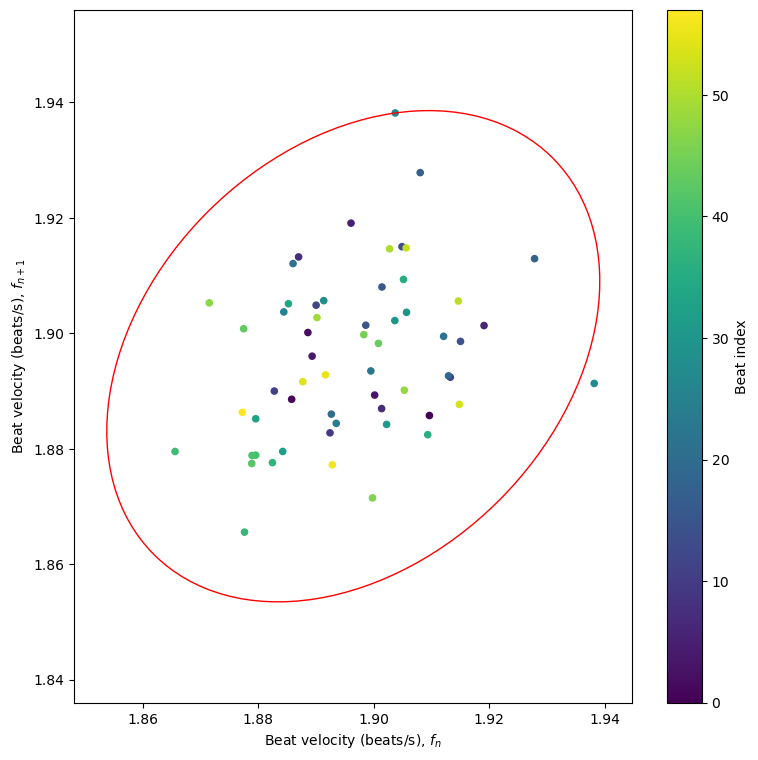

In [9]:
helper_functions.plot_poincare(gradients, frame_rate)

# Poincaré Plot

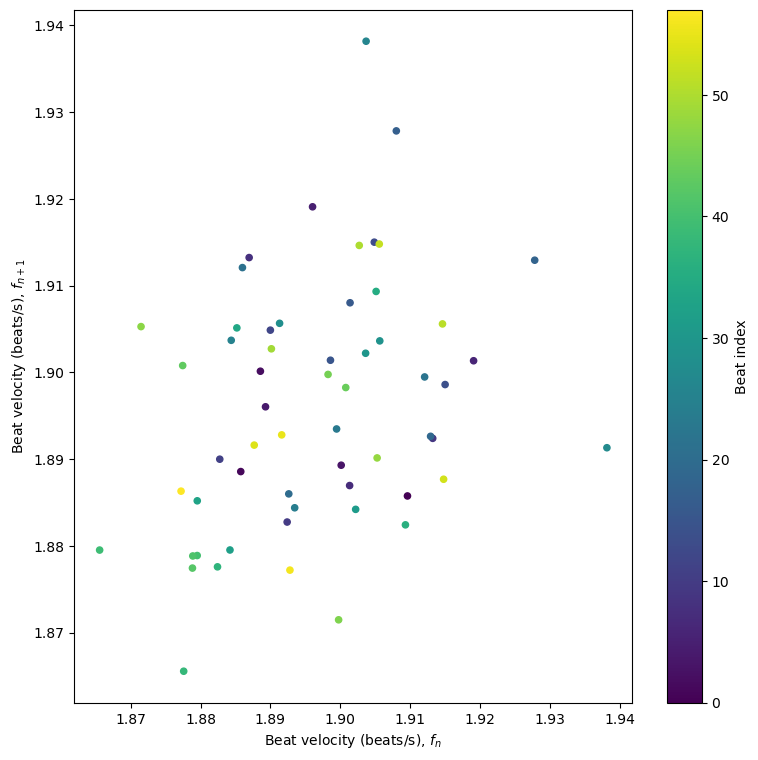

In [10]:
plt.figure(figsize=(9,9))
plt.scatter(helper_functions.radsperframe_to_bps(np.array(gradients[:-1]), frame_rate), helper_functions.radsperframe_to_bps(np.array(gradients[1:]), frame_rate), s = 20, c = range(len(gradients) - 1))
plt.colorbar(label = "Beat index")
plt.xlabel("Beat velocity (beats/s), $f_n$")
plt.ylabel("Beat velocity (beats/s), $f_{n+1}$")
plt.show()

In [11]:
np.cov(helper_functions.radsperframe_to_bps(np.array(gradients[:-1]), frame_rate), helper_functions.radsperframe_to_bps(np.array(gradients[1:]), frame_rate))

array([[2.02500242e-04, 6.16875407e-05],
       [6.16875407e-05, 2.01081249e-04]])

# HRV metrics
RMSSD

In [12]:
# RMSSD
RR_interval = 60*1000/((helper_functions.radsperframe_to_bps(np.array(gradients), frame_rate) * 60))
RMSSD = np.sqrt(np.mean(np.diff(RR_interval)) ** 2)
print(f"RMSSD: {RMSSD*1000:.5f} ms")

RMSSD: 111.53442 ms
